In [88]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

from torch.utils.data import DataLoader
from tqdm import tqdm, trange

from ribs.archives import GridArchive
from ribs.visualize import grid_archive_heatmap
from ribs.emitters import EvolutionStrategyEmitter
from ribs.schedulers import Scheduler

Creating the archive and running cma_mae

In [3]:
# objective function for cma-mae
def sphere(solution_batch):
    """Sphere function evaluation and measures for a batch of solutions.

    Args:
        solution_batch (np.ndarray): (batch_size, dim) batch of solutions.
    Returns:
        objective_batch (np.ndarray): (batch_size,) batch of objectives.
        measures_batch (np.ndarray): (batch_size, 2) batch of measures.
    """
    dim = solution_batch.shape[1]

    # Shift the Sphere function so that the optimal value is at x_i = 2.048.
    sphere_shift = 5.12 * 0.4

    # Normalize the objective to the range [0, 100] where 100 is optimal.
    best_obj = 0.0
    worst_obj = (-5.12 - sphere_shift)**2 * dim
    raw_obj = np.sum(np.square(solution_batch - sphere_shift), axis=1)
    objective_batch = (raw_obj - worst_obj) / (best_obj - worst_obj) * 100

    # Calculate measures.
    clipped = solution_batch.copy()
    clip_mask = (clipped < -5.12) | (clipped > 5.12)
    clipped[clip_mask] = 5.12 / clipped[clip_mask]
    measures_batch = np.concatenate(
        (
            np.sum(clipped[:, :dim // 2], axis=1, keepdims=True),
            np.sum(clipped[:, dim // 2:], axis=1, keepdims=True),
        ),
        axis=1,
    )

    return objective_batch, measures_batch

# max bound of the archive
max_bound = 100 / 2 * 5.12

# you have 2 archives because with CMA-MAE, you
# insert solutions into the archive if their obj
# is greater than their cell's threshold. This means
# underperforming solutions that are higher than t_e
# will be inserted, overruling the original solution.
# To prevent this, 2 archives are made with one storing
# the best solutions encountered in each cell and the other
# just storing solutions that overcome the threshold.
archive = GridArchive(solution_dim=100,
                      dims=(100, 100),
                      ranges=[(-max_bound, max_bound), (-max_bound, max_bound)],
                      learning_rate=0.01,
                      threshold_min=0.0)

result_archive = GridArchive(solution_dim=100,
                             dims=(100, 100),
                             ranges=[(-max_bound, max_bound), (-max_bound, max_bound)])

# emitters use improvement ranking and not 2imp
# to only consider difference between soln obj and
# threshold value. 
emitters = [
    EvolutionStrategyEmitter(
        archive,
        x0=np.zeros(100),
        sigma0=0.5,
        ranker="imp",
        selection_rule="mu",
        restart_rule="basic",
        batch_size=36,
    ) for _ in range(15)
]

scheduler = Scheduler(archive, emitters, result_archive=result_archive)

total_itrs = 10_000

# QD Loop
for itr in trange(1, total_itrs + 1, file=sys.stdout, desc='Iterations'):
    solution_batch = scheduler.ask()
    objective_batch, measure_batch = sphere(solution_batch)
    scheduler.tell(objective_batch, measure_batch)

    # Output progress every 500 iterations or on the final iteration.
    if itr % 500 == 0 or itr == total_itrs:
        tqdm.write(f"Iteration {itr:5d} | "
                   f"Archive Coverage: {result_archive.stats.coverage * 100:6.3f}%  "
                   f"Normalized QD Score: {result_archive.stats.norm_qd_score:6.3f}")


Iteration   500 | Archive Coverage: 54.010%  Normalized QD Score: 44.034
Iteration  1000 | Archive Coverage: 63.320%  Normalized QD Score: 50.173
Iteration  1500 | Archive Coverage: 68.950%  Normalized QD Score: 53.369
Iteration  2000 | Archive Coverage: 73.990%  Normalized QD Score: 56.263
Iteration  2500 | Archive Coverage: 76.530%  Normalized QD Score: 58.118
Iteration  3000 | Archive Coverage: 77.230%  Normalized QD Score: 59.132
Iteration  3500 | Archive Coverage: 78.160%  Normalized QD Score: 60.104
Iteration  4000 | Archive Coverage: 78.530%  Normalized QD Score: 60.622
Iteration  4500 | Archive Coverage: 78.680%  Normalized QD Score: 60.995
Iteration  5000 | Archive Coverage: 79.270%  Normalized QD Score: 61.438
Iteration  5500 | Archive Coverage: 79.530%  Normalized QD Score: 61.782
Iteration  6000 | Archive Coverage: 79.830%  Normalized QD Score: 62.066
Iteration  6500 | Archive Coverage: 80.000%  Normalized QD Score: 62.294
Iteration  7000 | Archive Coverage: 80.400%  Normal

Loading data from archive to be used to train mlp for approximating threshold.

In [83]:

# things that are new down here
# Idea is you want to take the solutions from the archive
# and use (a) their measures as training inputs and (b) their 
# thresholds as training targets, to train an MLP that can
# approximate the thresholds given solution measures.
# Inputs: measures, outputs: threshold

# get training data
class Train_Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

# only use the threshold archive    
def get_archive_data(archive):
    data = []
    for elite in archive:
        measures = elite["measures"]
        threshold = elite["threshold"]
        train_tuple = (measures, threshold)
        data.append(train_tuple)

    # loop over all measures to fill data with measures with no threshold
    centers = [(b[:-1] + b[1:]) / 2.0 for b in archive.boundaries]
    feature_coords = np.meshgrid(*centers)
    feature_grid = np.stack([x.ravel() for x in feature_coords], axis=1)

    i = 0
    for measures in feature_grid:
        occupied, elite = archive.retrieve_single(measures)
        if not occupied:
            train_tuple = (measures, 0.0) # 0.0 is min threshold value
            data.append(train_tuple)
            i += 1

    return data

def create_train_loader(data, batch_size, shuffle=True):
    x = [item[0] for item in data]

    # normalizing y
    y_mean = 0.0
    for item in data:
        y_mean += item[1]
    y_mean /= len(data)

    y_std = 0.0
    for item in data:
        y_std += (item[1] - y_mean)**2
    y_std = np.sqrt(y_std/len(data))

    y = [(item[1] - y_mean)/y_std for item in data]

    dataset = Train_Dataset(x, y)
    dataloader = DataLoader(dataset, batch_size, shuffle=shuffle)

    return dataloader, y_mean, y_std

batch_size = 16

threshold_archive_data = get_archive_data(archive)

train_loader, y_mean, y_std = create_train_loader(data=threshold_archive_data,
                                                  batch_size=batch_size,
                                                  shuffle=True)

Creating the mlp. Takes in measures (dim=2) as input and outputs threshold (dim=1)

In [90]:
discount_model = nn.Sequential(
    nn.Linear(2, 128),
    nn.LeakyReLU(), 
    nn.Linear(128, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 1)
).double()

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


discount_model.apply(initialize_weights)

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=128, out_features=1, bias=True)
)

Train the model on the data.

  0%|          | 0/100 [00:00<?, ?it/s]/Users/benryben/anaconda3/envs/archive-models/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/100 [00:01<02:46,  1.68s/it]

epoch: 0, loss: 2.984747078397225


  2%|▏         | 2/100 [00:03<02:36,  1.59s/it]

epoch: 1, loss: 1.0314829644397043


  3%|▎         | 3/100 [00:04<02:23,  1.48s/it]

epoch: 2, loss: 1.047461717577974


  4%|▍         | 4/100 [00:06<02:30,  1.56s/it]

epoch: 3, loss: 1.0459570692256697


  5%|▌         | 5/100 [00:08<02:59,  1.88s/it]

epoch: 4, loss: 1.039740404102111


  6%|▌         | 6/100 [00:09<02:36,  1.67s/it]

epoch: 5, loss: 1.0387396653878902


  7%|▋         | 7/100 [00:11<02:22,  1.53s/it]

epoch: 6, loss: 1.0615704600908207


  8%|▊         | 8/100 [00:12<02:18,  1.51s/it]

epoch: 7, loss: 1.0528372789373026


  9%|▉         | 9/100 [00:14<02:12,  1.46s/it]

epoch: 8, loss: 1.0613902125682655


 10%|█         | 10/100 [00:15<02:06,  1.41s/it]

epoch: 9, loss: 1.0737677771717553


 11%|█         | 11/100 [00:16<01:59,  1.34s/it]

epoch: 10, loss: 1.0501408602675981


 12%|█▏        | 12/100 [00:17<01:54,  1.30s/it]

epoch: 11, loss: 1.0604359997160755


 13%|█▎        | 13/100 [00:19<01:53,  1.31s/it]

epoch: 12, loss: 1.0623816251140545


 14%|█▍        | 14/100 [00:20<01:48,  1.26s/it]

epoch: 13, loss: 1.045017458668797


 15%|█▌        | 15/100 [00:21<01:43,  1.21s/it]

epoch: 14, loss: 1.0508849439235322


 16%|█▌        | 16/100 [00:22<01:39,  1.18s/it]

epoch: 15, loss: 1.061835465977073


 17%|█▋        | 17/100 [00:23<01:43,  1.25s/it]

epoch: 16, loss: 1.0472009078595577


 18%|█▊        | 18/100 [00:24<01:38,  1.20s/it]

epoch: 17, loss: 1.0598323783838828


 19%|█▉        | 19/100 [00:25<01:33,  1.16s/it]

epoch: 18, loss: 1.0450939557053365


 20%|██        | 20/100 [00:27<01:30,  1.13s/it]

epoch: 19, loss: 1.0409461322863136


 21%|██        | 21/100 [00:28<01:28,  1.12s/it]

epoch: 20, loss: 1.0549933263388431


 22%|██▏       | 22/100 [00:29<01:25,  1.10s/it]

epoch: 21, loss: 1.0436763074054236


 23%|██▎       | 23/100 [00:30<01:23,  1.09s/it]

epoch: 22, loss: 1.0424710431457298


 24%|██▍       | 24/100 [00:31<01:22,  1.09s/it]

epoch: 23, loss: 1.038788652449681


 25%|██▌       | 25/100 [00:32<01:31,  1.22s/it]

epoch: 24, loss: 1.0527742310772648


 26%|██▌       | 26/100 [00:34<01:41,  1.37s/it]

epoch: 25, loss: 1.0377776727969188


 27%|██▋       | 27/100 [00:35<01:41,  1.39s/it]

epoch: 26, loss: 1.0543138509707202


 28%|██▊       | 28/100 [00:37<01:43,  1.44s/it]

epoch: 27, loss: 1.0428970912475735


 29%|██▉       | 29/100 [00:38<01:40,  1.41s/it]

epoch: 28, loss: 1.0398548148088727


 30%|███       | 30/100 [00:40<01:36,  1.39s/it]

epoch: 29, loss: 1.0495192996274385


 31%|███       | 31/100 [00:41<01:34,  1.37s/it]

epoch: 30, loss: 1.036129153712494


 32%|███▏      | 32/100 [00:43<01:40,  1.48s/it]

epoch: 31, loss: 1.0396519865905751


 33%|███▎      | 33/100 [00:44<01:37,  1.45s/it]

epoch: 32, loss: 1.0470336651496153


 34%|███▍      | 34/100 [00:46<01:41,  1.54s/it]

epoch: 33, loss: 1.0354659417510879


 35%|███▌      | 35/100 [00:47<01:35,  1.47s/it]

epoch: 34, loss: 1.0468489243442827


 36%|███▌      | 36/100 [00:49<01:31,  1.44s/it]

epoch: 35, loss: 1.0437287202399634


 37%|███▋      | 37/100 [00:50<01:26,  1.38s/it]

epoch: 36, loss: 1.0401273749768265


 38%|███▊      | 38/100 [00:51<01:24,  1.37s/it]

epoch: 37, loss: 1.0427041502226633


 39%|███▉      | 39/100 [00:52<01:21,  1.33s/it]

epoch: 38, loss: 1.0367333070708984


 40%|████      | 40/100 [00:54<01:21,  1.35s/it]

epoch: 39, loss: 1.033678519545559


 41%|████      | 41/100 [00:55<01:17,  1.31s/it]

epoch: 40, loss: 1.0377095653372868


 42%|████▏     | 42/100 [00:56<01:15,  1.30s/it]

epoch: 41, loss: 1.0342467256010746


 43%|████▎     | 43/100 [00:58<01:12,  1.28s/it]

epoch: 42, loss: 1.034889449057383


 44%|████▍     | 44/100 [00:59<01:12,  1.30s/it]

epoch: 43, loss: 1.0360050726073067


 45%|████▌     | 45/100 [01:00<01:10,  1.29s/it]

epoch: 44, loss: 1.031769414638908


 46%|████▌     | 46/100 [01:01<01:07,  1.25s/it]

epoch: 45, loss: 1.0287077956290251


 47%|████▋     | 47/100 [01:02<01:04,  1.21s/it]

epoch: 46, loss: 1.0337917995315145


 48%|████▊     | 48/100 [01:04<01:03,  1.22s/it]

epoch: 47, loss: 1.0251733147817774


 49%|████▉     | 49/100 [01:05<01:06,  1.30s/it]

epoch: 48, loss: 1.038237909818136


 50%|█████     | 50/100 [01:07<01:12,  1.44s/it]

epoch: 49, loss: 1.0356039661311458


 51%|█████     | 51/100 [01:08<01:11,  1.47s/it]

epoch: 50, loss: 1.0324871593337697


 52%|█████▏    | 52/100 [01:10<01:09,  1.45s/it]

epoch: 51, loss: 1.0333314103709617


 53%|█████▎    | 53/100 [01:11<01:04,  1.38s/it]

epoch: 52, loss: 1.0269865752273746


 54%|█████▍    | 54/100 [01:13<01:05,  1.42s/it]

epoch: 53, loss: 1.029518525268061


 55%|█████▌    | 55/100 [01:14<01:03,  1.40s/it]

epoch: 54, loss: 1.0332332715919748


 56%|█████▌    | 56/100 [01:15<01:01,  1.41s/it]

epoch: 55, loss: 1.038805152487446


 57%|█████▋    | 57/100 [01:17<00:57,  1.34s/it]

epoch: 56, loss: 1.0300268178772511


 58%|█████▊    | 58/100 [01:18<00:53,  1.28s/it]

epoch: 57, loss: 1.0284253246419923


 59%|█████▉    | 59/100 [01:19<00:50,  1.24s/it]

epoch: 58, loss: 1.0361575810915635


 60%|██████    | 60/100 [01:20<00:47,  1.20s/it]

epoch: 59, loss: 1.0283734198913645


 61%|██████    | 61/100 [01:21<00:45,  1.17s/it]

epoch: 60, loss: 1.0238158684241376


 62%|██████▏   | 62/100 [01:22<00:43,  1.15s/it]

epoch: 61, loss: 1.0354267296725532


 63%|██████▎   | 63/100 [01:23<00:42,  1.14s/it]

epoch: 62, loss: 1.0220408185145156


 64%|██████▍   | 64/100 [01:24<00:40,  1.14s/it]

epoch: 63, loss: 1.0233187396408359


 65%|██████▌   | 65/100 [01:26<00:42,  1.21s/it]

epoch: 64, loss: 1.0280027780768002


 66%|██████▌   | 66/100 [01:28<00:48,  1.42s/it]

epoch: 65, loss: 1.0313066754346027


 67%|██████▋   | 67/100 [01:29<00:46,  1.40s/it]

epoch: 66, loss: 1.0223012111099783


 68%|██████▊   | 68/100 [01:30<00:44,  1.39s/it]

epoch: 67, loss: 1.0267442014207933


 69%|██████▉   | 69/100 [01:32<00:45,  1.48s/it]

epoch: 68, loss: 1.022913372094824


 70%|███████   | 70/100 [01:34<00:47,  1.59s/it]

epoch: 69, loss: 1.0282244678315948


 71%|███████   | 71/100 [01:36<00:47,  1.65s/it]

epoch: 70, loss: 1.031231814546657


 72%|███████▏  | 72/100 [01:38<00:51,  1.86s/it]

epoch: 71, loss: 1.0233772723066945


 73%|███████▎  | 73/100 [01:40<00:52,  1.93s/it]

epoch: 72, loss: 1.0318154918901745


 74%|███████▍  | 74/100 [01:42<00:47,  1.83s/it]

epoch: 73, loss: 1.024025485252193


 75%|███████▌  | 75/100 [01:44<00:52,  2.08s/it]

epoch: 74, loss: 1.023605265085943


 76%|███████▌  | 76/100 [01:46<00:44,  1.87s/it]

epoch: 75, loss: 1.0302247068268404


 77%|███████▋  | 77/100 [01:47<00:38,  1.68s/it]

epoch: 76, loss: 1.0230553622586724


 78%|███████▊  | 78/100 [01:49<00:36,  1.67s/it]

epoch: 77, loss: 1.0236876141378835


 79%|███████▉  | 79/100 [01:52<00:43,  2.07s/it]

epoch: 78, loss: 1.0239348199485747


 80%|████████  | 80/100 [01:53<00:39,  1.96s/it]

epoch: 79, loss: 1.0186189068462232


 81%|████████  | 81/100 [01:55<00:33,  1.79s/it]

epoch: 80, loss: 1.019107678773564


 82%|████████▏ | 82/100 [01:56<00:29,  1.65s/it]

epoch: 81, loss: 1.0233254351710472


 83%|████████▎ | 83/100 [01:57<00:26,  1.57s/it]

epoch: 82, loss: 1.0208258476321257


 84%|████████▍ | 84/100 [01:59<00:24,  1.51s/it]

epoch: 83, loss: 1.0184014406868482


 85%|████████▌ | 85/100 [02:00<00:21,  1.46s/it]

epoch: 84, loss: 1.0183118837086618


 86%|████████▌ | 86/100 [02:01<00:19,  1.39s/it]

epoch: 85, loss: 1.0208860509832292


 87%|████████▋ | 87/100 [02:03<00:17,  1.35s/it]

epoch: 86, loss: 1.0165956580208102


 88%|████████▊ | 88/100 [02:04<00:15,  1.32s/it]

epoch: 87, loss: 1.016848592163778


 89%|████████▉ | 89/100 [02:05<00:15,  1.38s/it]

epoch: 88, loss: 1.0168527857223828


 90%|█████████ | 90/100 [02:07<00:14,  1.48s/it]

epoch: 89, loss: 1.0253825976741298


 91%|█████████ | 91/100 [02:08<00:12,  1.43s/it]

epoch: 90, loss: 1.0176842513824849


 92%|█████████▏| 92/100 [02:10<00:11,  1.41s/it]

epoch: 91, loss: 1.0187362819081158


 93%|█████████▎| 93/100 [02:11<00:09,  1.38s/it]

epoch: 92, loss: 1.0140362561456437


 94%|█████████▍| 94/100 [02:12<00:07,  1.33s/it]

epoch: 93, loss: 1.0182801164756143


 95%|█████████▌| 95/100 [02:14<00:06,  1.31s/it]

epoch: 94, loss: 1.018093456669101


 96%|█████████▌| 96/100 [02:15<00:05,  1.35s/it]

epoch: 95, loss: 1.0129650218169997


 97%|█████████▋| 97/100 [02:17<00:04,  1.40s/it]

epoch: 96, loss: 1.0173531059616847


 98%|█████████▊| 98/100 [02:18<00:02,  1.35s/it]

epoch: 97, loss: 1.0184648855946217


 99%|█████████▉| 99/100 [02:19<00:01,  1.34s/it]

epoch: 98, loss: 1.0122107574352264


100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


epoch: 99, loss: 1.0120816785661306


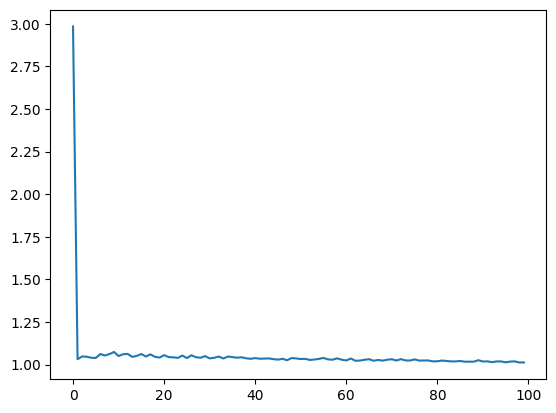

In [91]:
def train(model, 
          train_loader,
          num_iters, 
          optimizer,
          criterion, 
          learning_rate,
          device="cuda"):
    model.to(device)
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    
    all_epoch_loss = []

    for epoch in trange(num_iters):
        epoch_loss = 0.
        for i, (data_tuple) in enumerate(tqdm(train_loader)):
            measures = data_tuple[0]
            target_thresholds = data_tuple[1]
            prediction_thresholds = model(measures)

            loss = criterion(prediction_thresholds, target_thresholds)

            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss /= len(train_loader)
        all_epoch_loss.append(epoch_loss)

        print(f"epoch: {epoch}, loss: {epoch_loss}")

    return all_epoch_loss

criterion = nn.MSELoss()

all_epoch_loss = train(
    model=discount_model,
    train_loader=train_loader,
    num_iters=100,
    optimizer=torch.optim.Adam,
    criterion=criterion,
    learning_rate=5e-5,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

plt.plot(np.arange(100), all_epoch_loss)
plt.show()

Evaluate the model performance on original threshold archive.

In [92]:
def evaluate_model(model,
                   archive, 
                   y_mean, 
                   y_std):
    model.eval()

    # 1. grab all filled measures from archive
    all_measures = []
    all_true_thresholds = []
    for elite in archive:
        all_measures.append(elite["measures"])
        all_true_thresholds.append(elite["threshold"])

    print(all_true_thresholds[53:73])
    
    # 2. predict new thresholds using discount model
    all_pred_thresholds = []
    for measure in all_measures:
        normalized_pred_threshold = model(torch.tensor(measure, dtype=torch.float64))
        unnormalized_pred_threshold = normalized_pred_threshold * y_std + y_mean
        all_pred_thresholds.append(unnormalized_pred_threshold)
    
    print(all_pred_thresholds[53:73])

    # 3. calculate mean error
    mean_error = 0.0
    assert len(all_true_thresholds) == len(all_pred_thresholds)
    for i in range(len(all_true_thresholds)):
        mean_error += (all_true_thresholds[i] - all_pred_thresholds[i])
    return mean_error/len(all_true_thresholds)

mean_error = evaluate_model(model=discount_model,
                            archive=archive,
                            y_mean=y_mean,
                            y_std=y_std)

print(mean_error)

[92.57969772196775, 93.42046865950498, 90.2237322806343, 92.29718768377892, 92.71295058584457, 93.9122510820887, 91.5470483226715, 94.1385686684559, 93.09247498827263, 93.60325245272901, 90.87194018692412, 90.9995022345424, 91.55755490260718, 92.5032672294727, 93.05291564199736, 93.5648338790505, 93.43416376695822, 94.03598587275404, 91.10058821860835, 94.51409004395774]


[tensor([64.3825], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([64.2644], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([63.9391], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([64.0125], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([64.5771], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([64.9373], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([65.1188], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([64.8029], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([64.3054], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([63.8743], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([63.7511], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([63.7529], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([63.9405], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([64.3735], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([64.4917], dtype=torch.float64, grad_fn=<AddBackward0>), tensor([64.7191], dtype=torch.float64, 